In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
from scipy.special import logit, expit

In [2]:
import KECENI

In [3]:
from true_model import *

# save directory and random seed

In [4]:
save_dir = 'data'

In [5]:
np.random.seed(12345)

# parameters

In [6]:
n_sim = 80
n_pre = 4000
d_latent = 2

In [7]:
n_node = 600
rho = 2

# latent position and network

In [8]:
Zs_pre = np.random.uniform(-2, 2, (n_pre, d_latent))

In [9]:
Zs_pre, Zs_pre.shape

(array([[ 1.71846437, -0.73449778],
        [-1.26432475, -1.18175889],
        [ 0.27090012,  0.38217881],
        ...,
        [-0.49773864,  0.89424208],
        [-1.76833337, -1.62887432],
        [ 0.75789336, -0.64000873]]),
 (4000, 2))

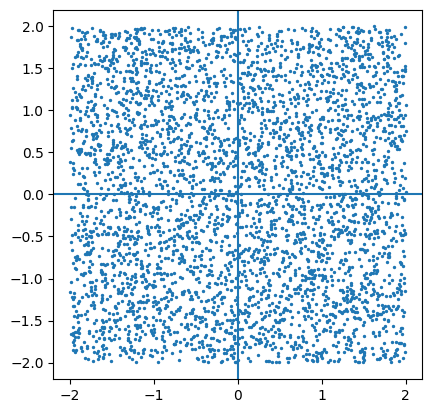

In [10]:
plt.gca().set_aspect('equal')
plt.scatter(*Zs_pre.T, s=2)
plt.axhline(y=0); plt.axvline(x=0)

In [11]:
# P = np.exp(-2-80*np.max(np.abs(Zs[:,None,:] - Zs[None,:,:])**2, axis=-1))
P = np.exp(- np.exp(10*np.max(np.abs(Zs_pre[:,None,:] - Zs_pre[None,:,:]), axis=-1)))

In [12]:
P, P.shape

(array([[3.67879441e-01, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.67879441e-01, 0.00000000e+00, ...,
         0.00000000e+00, 8.10480853e-68, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.67879441e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.67879441e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.10480853e-68, 0.00000000e+00, ...,
         0.00000000e+00, 3.67879441e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 3.67879441e-01]]),
 (4000, 4000))

In [13]:
ths = np.random.random((n_pre, n_pre))

In [14]:
Adj_pre = (ths <= rho * P).astype(int)
Adj_pre[np.arange(n_pre), np.arange(n_pre)] = 0
Adj_pre[*np.tril_indices(n_pre)] = Adj_pre.T[*np.tril_indices(n_pre)]

Text(0, 0.5, 'freq')

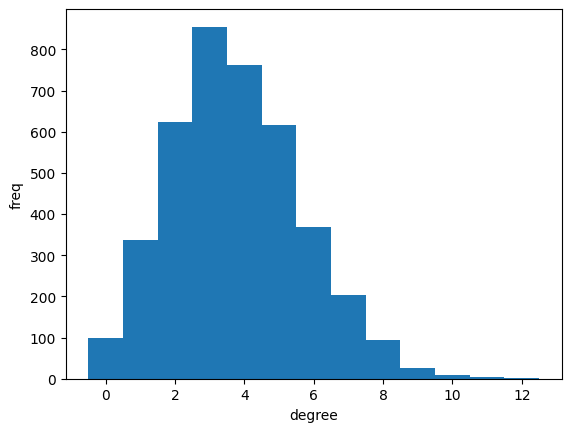

In [15]:
plt.hist(np.sum(Adj_pre,0), np.arange(np.max(np.sum(Adj_pre,0))+1)-0.5)
plt.xlabel('degree'); plt.ylabel('freq')

In [16]:
id_node = np.argsort(np.max(np.abs(Zs_pre), -1))[:n_node]

In [17]:
Adj = Adj_pre[id_node[:,None],id_node]
Zs = Zs_pre[id_node]

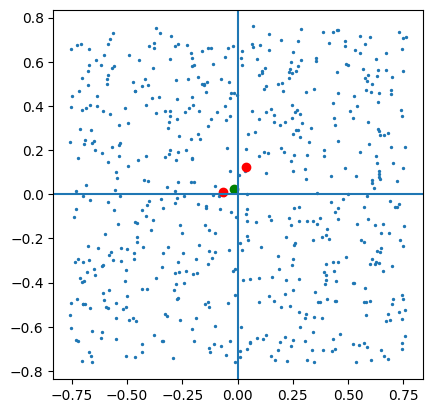

In [18]:
plt.gca().set_aspect('equal')
plt.scatter(*Zs.T, s=2)
plt.scatter(*Zs[Adj[0]==1].T, color='red')
plt.scatter(*Zs[0], color='green')
plt.axhline(y=0); plt.axvline(x=0)

In [19]:
G = KECENI.Graph(Adj, Zs)

In [20]:
row, col = np.where(Adj != 0)

Text(0, 0.5, '$Z_{i2}$')

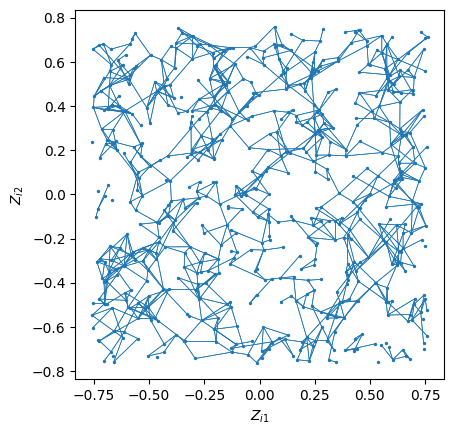

In [21]:
plt.gca().set_aspect('equal')
plt.scatter(*Zs.T, s=2)

for i, (r,c) in enumerate(zip(row, col)):
    plt.plot(*Zs[[r,c]].T, color='C0', linewidth=0.5)
    
plt.xlabel(r'$Z_{i1}$'); plt.ylabel(r'$Z_{i2}$')

In [22]:
data_latent = pd.DataFrame({'Z1': Zs[:,0], 'Z2': Zs[:,1]})
data_network = pd.DataFrame({'row': row+1, 'col': col+1})

In [23]:
data_latent.to_feather('%s/latent.feather'%save_dir)
data_network.to_feather('%s/network.feather'%save_dir)

# features

In [24]:
for i_sim in np.arange(n_sim):
    Xs = rX(1, np.arange(n_node), G)[0]

    ps = np.array([
        pij(1, Xs[G.N1(i)], G.sub(G.N1(i))) 
        for i in np.arange(n_node)
    ])

    Ts = np.random.binomial(1, ps) 

    ms = np.array([
        mu(Ts[G.N1(i)], Xs[G.N2(i)], G.sub(G.N2(i))) 
        for i in np.arange(n_node)
    ])

    Ys = np.random.normal(ms, 1)

    data_feature = pd.DataFrame({
        'X1': Xs[:,0], 'X2': Xs[:,1], 'X3': Xs[:,2],
        'p': ps, 'T': Ts, 'm': ms, 'Y': Ys
    })

    data_feature.to_feather(
        '%s/feature_%.3d.feather'%(save_dir, i_sim)
    )

# check

In [25]:
i_sim = 1

In [26]:
data_feature = pd.read_feather(
    '%s/feature_%.3d.feather'%(save_dir, i_sim)
)

(array([ 12.,  26.,  75.,  91., 106.,  97.,  90.,  58.,  39.,   6.]),
 array([0.04652654, 0.13731896, 0.22811138, 0.3189038 , 0.40969622,
        0.50048864, 0.59128106, 0.68207348, 0.7728659 , 0.86365832,
        0.95445074]),
 <BarContainer object of 10 artists>)

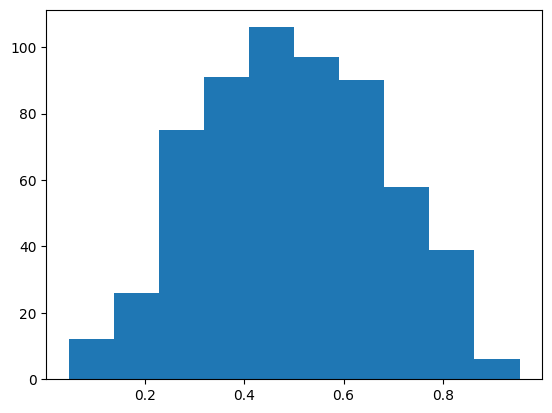

In [27]:
plt.hist(data_feature['p'])

(array([  5.,  21.,  47.,  99., 164., 113.,  95.,  39.,  16.,   1.]),
 array([-8.13497542, -6.41978686, -4.7045983 , -2.98940974, -1.27422118,
         0.44096738,  2.15615593,  3.87134449,  5.58653305,  7.30172161,
         9.01691017]),
 <BarContainer object of 10 artists>)

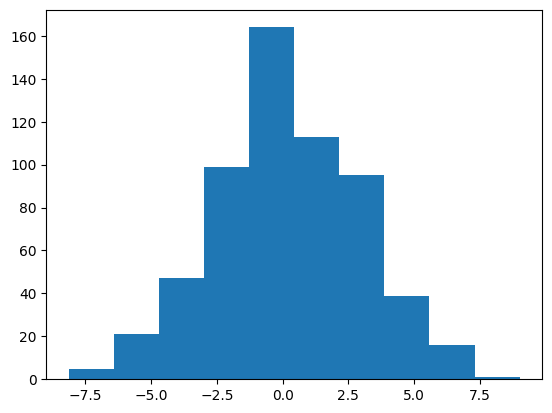

In [28]:
plt.hist(data_feature['Y'])